In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import sqrt
from math import exp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


# Settings

In [2]:
C = 0.9
R = 3

# Code

In [3]:
# parameters
r_min = 0.2
r_max = 2.0
c = 1.5
a = 0.8
b = 1.4
count1 = 500
count2 = 1500
h1 = (r_max - r_min) / count1
h2 = (r_max - r_min) / count2
tau1 = C * h1 / c
tau2 = C * h2 / c

timeBegin, timeEnd = 1.2, 1.8

In [4]:
def r(i, h):
    return r_min + (i - 0.5)*h

In [5]:
analSol = lambda t, r: r ** ((1 - R) / 2) * U(c * t - r)

f = lambda t, r: c**2 * (R - 1) * (R - 3) * U(c * t - r) / 4 / r ** ((R + 3) / 2)

def borderConditions(t, r):
    return (1 - R) / 2 * r ** (-(1 + R) / 2) * U(c * t - r) - r ** ((1 - R) / 2) * UDerivate(c * t - r)



In [6]:
def gen_next(u, u_prev, h, tau, t):
    u_next = [0 for _ in range(len(u))]
    for i in range(1, len(u) - 1):
        u_next[i] = 2 * u[i] - u_prev[i] + (tau**2 * c**2) / (r(i, h)**(R-1) * h) * (((r(i + 0.5, h))**(R-1) * (u[i+1] - u[i]) / h) - 
                                                                                     ((r(i - 0.5, h))**(R-1) * (u[i] - u[i-1]) / h)) + tau**2 * f(t - tau, r(i, h))
    u_next[0] = u_next[1] - h * borderConditions(t, r_min)
    u_next[-1] = u_next[-2] + h * borderConditions(t, r_max)
    return u_next

In [7]:
def U(r):
    if a < r < b:
        return exp((-4*(2*r - (a + b))**2) / ((b - a)**2 - (2*r - (a + b))**2))
    return 0

In [8]:
def UDerivate(r):
    return -4 * U(r) * (4 * (2 * r - b - a) ** 3 + 4 * (2 * r - b - a) * ((b - a) ** 2 - (2 * r - b - a) ** 2)) / (
                (b - a) ** 2 - (2 * r - b - a) ** 2)

In [9]:
def calc_C(u1, u2):
    if len(u1) == count1 + 2:
        u1_ = u1[1:-1]
        u2_ = u2[1:-1]
        ans = [abs(u1_[i] - u2_[i]) for i in range(len(u2_))]
    else:
        u1_ = u1[2:-2:3]
        u2_ = u2[1:-1]
        ans = [abs(u1_[i] - u2_[i]) for i in range(len(u1_))]
    return max(ans)

In [10]:
def calc_L2(u1, u2):
    if len(u1) == count1 + 2:
        u1_ = u1[1:-1]
        u2_ = u2[1:-1]
    else:
        u1_ = u1[2:-2:3]
        u2_ = u2[1:-1]
    ans = [(abs(u1_[i] - u2_[i]))**2 for i in range(len(u1_))]
    return sqrt(sum(ans))

In [11]:
t = timeBegin
u01 = [analSol(timeBegin, r(i, h1)) for i in range(count1 + 2)]
u02 = [analSol(timeBegin, r(i, h2)) for i in range(count2 + 2)]
u_next1 = [analSol(timeBegin + tau1, r(i, h1)) for i in range(count1 + 2)]
u_next2 = [analSol(timeBegin + tau2, r(i, h2)) for i in range(count2 + 2)]
for i in range(2):
    y2 = gen_next(u_next2, u02, h2, tau2, timeBegin + (i + 2)*tau2)
    u_next2, u02 = y2, u_next2

In [12]:
norm_c = []
norm_L2 = []
time = []
t = timeBegin + tau1
with tqdm(total=int((timeEnd - timeBegin)/tau1)) as pbar:
    while t < timeEnd:
        y1 = gen_next(u_next1, u01, h1, tau1, t + tau1)
        u_next1, u01 = y1, u_next1
        for i in range(3):
            y2 = gen_next(u_next2, u02, h2, tau2, t + (i + 1) * tau2)
            u_next2, u02 = y2, u_next2
        analit_sol = [analSol(t + tau1, r(i, h1)) for i in range(count1 + 2)]
        norm_c.append(calc_C(u_next1, analit_sol)  / calc_C(u_next2, analit_sol))
        norm_L2.append(calc_L2(u_next1, analit_sol) / calc_L2(u_next2, analit_sol))
        time.append(t + tau1)
        pbar.update(1)
        t += tau1

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 52.94it/s]


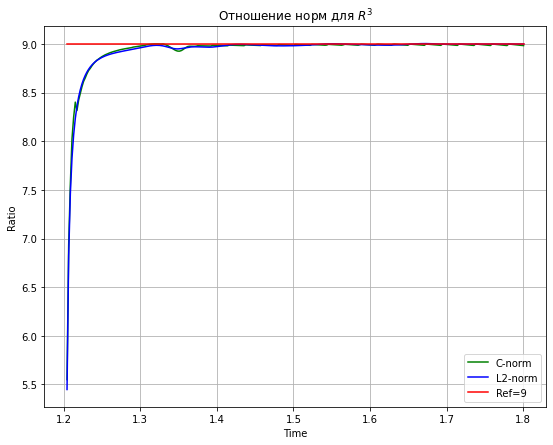

In [13]:
fig, ax = plt.subplots(figsize = (9, 7))
ax.plot(time, norm_c, 'g')
ax.plot(time, norm_L2, 'b')
ax.plot(time, [9 for _ in range(len(time))], 'r')
ax.set_title("Отношение норм для $R^3$")
ax.grid()
ax.legend(['C-norm', 'L2-norm', 'Ref=9'], loc=4)
ax.set_xlabel('Time')
ax.set_ylabel('Ratio')

plt.show()